In [1]:
import pandas as pd
import numpy as np

In [2]:
cbcl = pd.read_csv('cbcl_1_5-2023-07-21.csv')
iq = pd.read_csv("iq-2023-07-21.csv")

basic = pd.read_csv("basic_medical_screening-2023-07-21.csv")
dcdq = pd.read_csv("dcdq-2023-07-21.csv")
vineland = pd.read_csv("vineland-3-2023-07-21.csv")
rbsr = pd.read_csv("rbsr-2023-07-21.csv")
scq = pd.read_csv("scq-2023-07-21.csv")

background = pd.read_csv("background_history_child-2023-07-21.csv")

core = pd.read_csv("core_descriptive_variables-2023-07-21.csv")
indi = pd.read_csv("individuals_registration-2023-07-21.csv")

expiq = pd.read_csv("predicted_iq_experimental-2023-07-21.csv")

C:\Users\DELL\AppData\Local\Temp\ipykernel_7340\2912893350.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  dcdq = pd.read_csv("dcdq-2023-07-21.csv")
C:\Users\DELL\AppData\Local\Temp\ipykernel_7340\2912893350.py:12: DtypeWarning: Columns (22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  core = pd.read_csv("core_descriptive_variables-2023-07-21.csv")
C:\Users\DELL\AppData\Local\Temp\ipykernel_7340\2912893350.py:13: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  indi = pd.read_csv("individuals_registration-2023-07-21.csv")


In [3]:
background['regress_lang_return_y_n'].value_counts(dropna=False)

regress_lang_return_y_n
NaN    32622
1.0     9695
0.0     5266
Name: count, dtype: int64

# Missing Data handling

In [4]:
# background history

paras = [
    'family_hx_asd_mat_aunt_uncle', 
    'intervention_counseling', 
    'intervention_medication', 
    'intervention_ot_fine_mot', 
    'intervention_ot_sensory', 
    'intervention_social_skills', 
    'intervention_speech_language', 
    #'regress_lang_return_y_n', 
    'sped_504', 
    'sped_aide', 
    'sped_asd_class_ft', 
    'sped_birth_to_three', 
    'sped_iep_asd', 
    'sped_iep_other', 
    'sped_ot', 
    'sped_other', 
    'sped_other_class_ft', 
    'sped_other_class_pt', 
    'sped_preschool', 
    'sped_priv_asd', 
    'sped_pt', 
    'sped_soc_skills', 
    'sped_speech'
]

background[paras] = background[paras].fillna(0)

In [5]:
# basic medical screening

paras = ["dev_id",
    "dev_lang_dis",
    "mood_or_anx",
    "neuro_oth_calc",
    "dev_speech",
    "med_cond_birth",
    "med_cond_neuro",
    "med_cond_visaud",
    "mood_anx",
    "mood_soc_anx",
    "attn_behav",
    "behav_adhd",
    "birth_prem"]

basic[paras] = basic[paras].fillna(0)

# Data merging

In [6]:
# modified code to include all parameters for calculating cognitive impairment
# dfs = [iq, vineland, basic, cbcl, core, background, rbsr, dcdq, indi, scq]
dfs = [basic, indi, core, scq, background, rbsr, dcdq, vineland, cbcl, iq, expiq]  # SORTED in descending order
total = dfs[0].copy(deep=True)

suffixes = ['_' + str(i) for i in range(1, len(dfs))]

for df, sfx in zip(dfs[1:], suffixes):
    total = pd.merge(total, df, on='subject_sp_id', how="outer", suffixes=(sfx, ''))

In [7]:
total.shape

(330023, 777)

# Filtering

## FSIQ null values

In [8]:
total_drop_iq_na = total.dropna(subset=['fsiq_score'])
#total_drop_iq_na.shape

# Making demographic subsets

In [9]:
less5_drop_iq_na = total_drop_iq_na[total_drop_iq_na['age_at_eval_months_3'] < 61]
less5_drop_iq_na.shape

(1043, 777)

In [10]:
less18 = total_drop_iq_na[total_drop_iq_na['age_at_eval_months_3'] < 217]
less18.shape

(3450, 777)

# Computed deriv_cog_impair

In [14]:
# maybe skip this code and use the available derived_cog_impair parameter from expiq df

def check_cognitive_impairment(row):
    if row['invalid'] != 1:
        if pd.notnull(row['fsiq_score']) or pd.notnull(row['nviq_score']):
            if pd.notnull(row['fsiq_score']) and row['fsiq_score'] < 80:
                return 1
            elif pd.notnull(row['nviq_score']) and row['nviq_score'] < 80:
                return 1
            else:
                return 0
        elif pd.notnull(row['fsiq_ratio']) or pd.notnull(row['nviq_ratio']):
            if pd.notnull(row['fsiq_ratio']) and row['fsiq_ratio'] < 80:
                return 1
            elif pd.notnull(row['nviq_ratio']) and row['nviq_ratio'] < 80:
                return 1
            else:
                return 0
        elif pd.notnull(row['intel_class']):
            if row['intel_class'] in ['profound', 'severe', 'moderate', 'mild', 'border', 'id_nos']:
                return 1
            else:
                return 0
        elif pd.notnull(row['communication_standard']):
            if row['communication_standard'] < 80:
                return 1
            else:
                return 0
        elif pd.notnull(row['cognitive_impairment_latest']):
            if (row['cognitive_impairment_latest'] == 1):
                return 1
            else:
                return 0
        elif pd.notnull(row['age_at_registration_years']) and pd.notnull(row['language_level_latest']):
            if (row['age_at_registration_years'] >= 4) and (row['language_level_latest'] != 'Uses longer sentences of his/her own and is able to tell you something that happened'):
                return 1
            else:
                return 0
        elif pd.notnull(row['cog_age_level']):
            if row['cog_age_level'] == 'signif_below_age' : 
                return 1
            else:
                return 0
        elif pd.notnull(row['cog_test_score']):
            if row['cog_test_score'] in ['24_below', '25_39', '40_54', '55_69', '70_79']:
                return 1
            else:
                return 0
        elif pd.notnull(row['age_at_registration_months']) and pd.notnull(row['motor_able']) and pd.notnull(row['dev_lang']):
            if (row['age_at_registration_months'] >= 60) and (row['motor_able'] != 1) and (row['dev_lang'] == 1):
                return 1
            else:
                return 0
        elif pd.notnull(row['regress_lang_return_y_n']) and pd.notnull(row['language_level_at_enrollment']):
            if (row['regress_lang_return_y_n'] == 4) and (row['language_level_at_enrollment'] != 'Uses longer sentences of his/her own and is able to tell you something that happened'):
                return 1
            else:
                return 0
        elif pd.notnull(row['age_at_eval_years']) and pd.notnull(row['cog_age_equivalent']) and pd.notnull(row['cog_age_equivalent_in_months']):
            if (row['age_at_eval_years'] < 15) and pd.notnull(row['cog_age_equivalent']) and (row['cog_age_equivalent_in_months']/12*100 < 80):
                return 1
            else:
                return 0

# Define the mapping for cog_age_equivalent
cog_age_map = {
    'under_12mos': 6,
    '12_18mos': 15,
    '18_24mos': 21,
    '2_3years': 30,
    '4_5years': 54,
    '6_8years': 84,
    '9_11years': 120,
    '12_or_older': 144
}

# Add a new column 'cog_age_equivalent_in_months' based on 'cog_age_equivalent'
less18.loc[:, 'cog_age_equivalent_in_months'] = less18['cog_age_equivalent'].apply(lambda x: cog_age_map.get(x, 0))


# create a parameter called deriv_cog_impair in less5 df
less18.loc[:, 'deriv_cog_impair'] = None

# Apply the function to each row of the DataFrame
less18.loc[:, 'deriv_cog_impair'] = less18.apply(check_cognitive_impairment, axis=1)


# Compare the overlap/matching of the two variables

In [ ]:
# Calculate the number of rows where the values in 'derived_cog_impair' and 'deriv_cog_impair' are the same
same_values_count = less18_drop_iq_na['derived_cog_impair'].eq(less18_drop_iq_na['deriv_cog_impair']).sum()

# Calculate the number of rows where the values in 'derived_cog_impair' and 'deriv_cog_impair' are different
diff_values_count = (~less18_drop_iq_na['derived_cog_impair'].eq(less18_drop_iq_na['deriv_cog_impair'])).sum()

# Print the results
print("Number of rows where the values are the same:")
print(same_values_count)

print("\nNumber of rows where the values are different:")
print(diff_values_count)

In [ ]:
# Calculate the number of rows where the values in 'derived_cog_impair' and 'deriv_cog_impair' are different
# Using groupby on the two columns to find all possible combinations and their counts
mismatch_combinations = less18_drop_iq_na.groupby(
    ['derived_cog_impair', 'deriv_cog_impair']
).size().reset_index(name='count')

# Filter only mismatched values
mismatch_combinations = mismatch_combinations[
    mismatch_combinations['derived_cog_impair'] != mismatch_combinations['deriv_cog_impair']
]

# Print the results
print("Count of each combination of mismatched values:")
print(mismatch_combinations)

**Conclusion**

3405 matching
27 mismatching
580 either both or one value missing, hence mismatched

the parameter we computed (deriv_cog_impair) has less missing values compared to the existing parameter (derived_cog_impair)

# Create new parameter for FSIQ<70 measure

In [12]:
# Create new columns using .loc
less18.loc[:, 'fsiq_70'] = None
less18.loc[:, 'fsiq_80'] = None

less18.loc[less18['fsiq_score'] < 70, 'fsiq_70'] = 1
less18.loc[less18['fsiq_score'] >= 70, 'fsiq_70'] = 0

less18.loc[less18['fsiq_score'] < 80, 'fsiq_80'] = 1
less18.loc[less18['fsiq_score'] >= 80, 'fsiq_80'] = 0

In [15]:
less18['fsiq_80'].value_counts(dropna=False)

fsiq_80
0    1750
1    1700
Name: count, dtype: int64

# Dataset export

In [19]:
# save CSV files
less18.to_csv("less18_fsiq.csv", index=False)

In [16]:
ref129_less18 = less18.copy()
#ref129_less5 = less5.copy()

# minimal dataset (129 parameters)

In [17]:
# extract required parameters

model_para = [
    # 
    "subject_sp_id",
    "asd_5",
    "derived_cog_impair",
    "fsiq",
    "fsiq_score",
    "fsiq_70",
    "fsiq_80",
    #
    # BACKGROUND --------------
    "age_onset_mos",   # standardisation
    "cog_age_level",   # ENCODING
    "family_hx_asd_mat_aunt_uncle",
    "father_highest_education",
    "fed_self_spoon_age_mos",
    "function_age_level",   # ENCODING
    "hand",
    "intervention_counseling",
    "intervention_medication",
    "intervention_ot_fine_mot",
    "intervention_ot_sensory",
    "intervention_social_skills",
    "intervention_speech_language",
    "language_age_level",   # ENCODING
    "mother_highest_education",
    "onset_concern",
    "plateau_y_n",
    "regress_lang_return_y_n",
    "regress_lang_time_return",
    "regress_lang_y_n",
    "repeat_grade",
    "smiled_age_mos",
    "sped_504",
    "sped_aide",
    "sped_asd_class_ft",
    "sped_birth_to_three",
    "sped_iep_asd",
    "sped_iep_other",
    "sped_ot",
    "sped_other",
    "sped_other_class_ft",
    "sped_other_class_pt",
    "sped_preschool",
    "sped_priv_asd",
    "sped_pt",
    "sped_soc_skills",
    "sped_speech",
    "sped_y_n",
    "support_require",
    # 
    # SCQ -----------
    "q01_phrases",
    "q02_conversation",
    "q04_inappropriate_question",
    "q06_invented_words",
    "q09_expressions_appropriate",
    "q10_hand_tool",
    "q13_interests_intensity",
    "q14_senses",
    "q18_objects_carry",
    "q20_talk_friendly",
    "q21_copy_you",
    "q22_point_things",
    "q23_gestures_wanted",
    "q24_nod_head",
    "q25_shake_head",
    "q26_look_directly",
    "q28_things_interested",
    "q29_share",
    "q30_join_enjoyment",
    "q31_comfort",
    "q32_help_attention",
    "q33_range_expressions",
    "q35_make_believe",
    "q36_same_age",
    "q38_pay_attention",
    # 
    # DCDQ --------------------------
    "q02_catch_ball",
    "q05_run_fast_similar",
    "q06_plan_motor_activity",
    "q09_appropriate_tension_printing_writing",
    "q10_cuts_pictures_shapes",
    "q11_likes_sports_motors_skills",
    "q13_quick_competent_tidying_up",
    "fine_motor_handwriting",
    #
    # basic medical screening --------------
    "dev_id",
    "dev_lang_dis",
    "mood_or_anx",
    "neuro_oth_calc",
    "dev_speech",
    "med_cond_birth",
    "med_cond_neuro",
    "med_cond_visaud",
    "mood_anx",
    "mood_soc_anx",
    "attn_behav",
    "behav_adhd",
    "birth_prem",
    # 
    # individuals registration -------------
    "diagnosis_age",
    "ASD_services",
    "iep_asd",
    "cognitive_impairment_at_enrollment",   # ENCODING
    "language_level_at_enrollment",   # ENCODING
    # 
    # RBSR --------------------
    "q01_whole_body",
    "q03_hand_finger",
    "q07_hits_self_body",
    "q08_hits_self_against_object",
    "q09_hits_self_with_object",
    "q12_rubs",
    "q16_complete",
    "q18_checking",
    "q19_counting",
    "q22_touch_tap",
    "q32_insists_walking",
    "q27_play",
    "q28_communication",
    "q29_things_same_place",
    "q31_becomes_upset",
    "q34_dislikes_changes",
    "q35_insists_door",
    "q36_likes_piece_music",
    "q39_insists_time",
    "q41_strongly_attached",
    "q43_fascination_movement"
]


ref129_less18 = ref129_less18[model_para]
#ref129_less5 = ref129_less5[model_para]

In [18]:
ref129_less18.rename(columns={'asd_5': 'asd'}, inplace=True)
#ref129_less5.rename(columns={'asd_5': 'asd'}, inplace=True)

## encoding and elimination of extra parameters

In [19]:
# perform one hot encoding of the dataframe

# Identify categorical columns
categorical_columns = ['cog_age_level', 'father_highest_education', 'function_age_level', 'hand', 'language_age_level',
                   'mother_highest_education', 'onset_concern', 'regress_lang_time_return', 'support_require',
                   'ASD_services', 'iep_asd', 'cognitive_impairment_at_enrollment', 'language_level_at_enrollment']

# One-hot encode categorical columns
ref129_less18_encoded = pd.get_dummies(ref129_less18, columns=categorical_columns)
#ref129_less5_encoded = pd.get_dummies(ref129_less5, columns=categorical_columns)

In [20]:
# drop paramters

drop_para = [
    'father_highest_education_associate_degree',
    'father_highest_education_did_not_attend_high_school',
    'father_highest_education_ged_diploma',
    'father_highest_education_graduate_or_professional_degree',
    'father_highest_education_some_high_school',
    'father_highest_education_trade_school',
    'function_age_level_above_age',
    'function_age_level_at_age',
    'function_age_level_slight_below_age',
    'hand_left',
    'hand_not_able',
    'language_age_level_at_age',
    'language_age_level_slight_below_age',
    'mother_highest_education_associate_degree',
    'mother_highest_education_baccalaureate_degree',
    'mother_highest_education_did_not_attend_high_school',
    'mother_highest_education_ged_diploma',
    'mother_highest_education_some_college',
    'mother_highest_education_some_high_school',
    'mother_highest_education_trade_school',
    'onset_concern_change_loss',
    'onset_concern_something_else',
    'onset_concern_unusual_habits',
    'onset_concern_unusual_speech',
    'support_require_substantial',
    'ASD_services_False',
    'iep_asd_False',
    'cognitive_impairment_at_enrollment_False',
    'language_level_at_enrollment_No words/does not speak'
]


# ref129_dropped = ref129_encoded.drop(columns=drop_para) 

ref129_less18_encoded = ref129_less18_encoded.drop(columns=drop_para) 
#ref129_less5_encoded = ref129_less5_encoded.drop(columns=drop_para) 

## Boolean to 0/1 replacement

In [21]:
# List of parameters to replace
parameters_to_replace = [
    'cog_age_level_above_age', 'cog_age_level_at_age', 'cog_age_level_signif_below_age',
    'cog_age_level_slight_below_age', 'father_highest_education_baccalaureate_degree',
    'father_highest_education_high_school_graduate', 'father_highest_education_some_college',
    'function_age_level_signif_below_age', 'hand_ambi', 'hand_right',
    'language_age_level_above_age', 'language_age_level_signif_below_age',
    'mother_highest_education_graduate_or_professional_degree',
    'mother_highest_education_high_school_graduate', 'onset_concern_late_speech',
    'onset_concern_late_walk', 'onset_concern_mood', 'onset_concern_social',
    'regress_lang_time_return_5_or_more_yr', 'regress_lang_time_return_6_to_12_mo',
    'regress_lang_time_return_bt_1_to_2_yr', 'regress_lang_time_return_bt_2_to_3_yr',
    'regress_lang_time_return_bt_3_to_4_yr', 'regress_lang_time_return_bt_4_to_5_yr',
    'regress_lang_time_return_less_than_6_mo', 'support_require_minimal_no_support',
    'support_require_some_support', 'support_require_very_substantial', 'ASD_services_True',
    'iep_asd_True', 'cognitive_impairment_at_enrollment_True',
    'language_level_at_enrollment_Combines 3 words together into short sentences',
    'language_level_at_enrollment_Uses longer sentences of his/her own and is able to tell you something that happened',
    'language_level_at_enrollment_Uses single words meaningfully (for example, to request)'
]

# Iterate through the list of parameters and perform replacement
for param in parameters_to_replace:
    ref129_less18_encoded[param] = ref129_less18_encoded[param].map({True: 1, False: 0})
    #ref129_less5_encoded[param] = ref129_less5_encoded[param].map({True: 1, False: 0})

# Missing values evaluation

- lots of SCQ and RBSR parameters are missing in a huge portion of dataset
- basic medical screening parameters can be imputed with 0 

- RBSR : most para missing in 1100_ entries
- SCQ : most parameters missing in 410+ entries
    - "q02_conversation", "q04_inappropriate_question", "q06_invented_words" missing in 1100+ entries
- background history
    - cannot be imputed:
        - age_onset_mos, fed_self_spoon_age_mos, smiled_age_mos (numerical)
        - plateau_y_n, regress_lang_return_y_n, regress_lang_y_n, repeat_grade ( 1|0 instead of 1|null )
        - dropping **regress_lang_return_y_n** reduced data size from 2676 to 779. this parameter might be imputed with 0.
    
**Criteria parameters (least missing)**

- RBSR => q28_communication
- SCQ => q18_objects_carry

## Dropping parameters

In [31]:
ref129_less18 = ref129_less18_encoded.copy()
ref129_less18.shape

(3450, 139)

In [32]:
# background

paras = ['age_onset_mos', 'fed_self_spoon_age_mos', 'smiled_age_mos', 
        'plateau_y_n', 'regress_lang_y_n', 'repeat_grade' #, 'regress_lang_return_y_n' 
        ]
ref129_less18 = ref129_less18.dropna(subset=paras)

ref129_less18.shape

(2424, 139)

- impute the remaining parameters, in the original dataset
- most should get filled up
- but some will remain empty, meaning their records are not present in the original scq file. those will be dropped.

In [33]:
# SCQ

paras = ["q01_phrases",
    #"q02_conversation",
    #"q04_inappropriate_question",
    #"q06_invented_words",
    "q09_expressions_appropriate",
    "q10_hand_tool",
    "q13_interests_intensity",
    "q14_senses",
    "q18_objects_carry",
    "q20_talk_friendly",
    "q21_copy_you",
    "q22_point_things",
    "q23_gestures_wanted",
    "q24_nod_head",
    "q25_shake_head",
    "q26_look_directly",
    "q28_things_interested",
    "q29_share",
    "q30_join_enjoyment",
    "q31_comfort",
    "q32_help_attention",
    "q33_range_expressions",
    "q35_make_believe",
    "q36_same_age",
    "q38_pay_attention"]

ref129_less18 = ref129_less18.dropna(subset=paras)

ref129_less18.shape

(2267, 139)

In [34]:
# DCDQ

paras = [
    'q02_catch_ball',
    'q05_run_fast_similar',
    'q06_plan_motor_activity',
    'q09_appropriate_tension_printing_writing',
    'q10_cuts_pictures_shapes',
    'q11_likes_sports_motors_skills',
    'q13_quick_competent_tidying_up',
    'fine_motor_handwriting'
]

ref129_less18 = ref129_less18.dropna(subset=paras)

ref129_less18.shape

(1928, 139)

In [35]:
# RBSR

paras = [
    'diagnosis_age',
    'q01_whole_body',
    'q03_hand_finger',
    'q07_hits_self_body',
    'q08_hits_self_against_object',
    'q09_hits_self_with_object',
    'q12_rubs',
    'q16_complete',
    'q18_checking',
    'q19_counting',
    'q22_touch_tap',
    'q32_insists_walking',
    'q27_play',
    'q28_communication',
    'q29_things_same_place',
    'q31_becomes_upset',
    'q34_dislikes_changes',
    'q35_insists_door',
    'q36_likes_piece_music',
    'q39_insists_time',
    'q41_strongly_attached',
    'q43_fascination_movement'
]

ref129_less18 = ref129_less18.dropna(subset=paras)

ref129_less18.shape

(1838, 139)

In [36]:
# dropping troublemaker parameters

paras = [
    #'derived_cog_impair',
    #'regress_lang_return_y_n', # might be imputed
    'q02_conversation',
    'q04_inappropriate_question',
    'q06_invented_words'
]

ref129_less18 = ref129_less18.dropna(subset=paras)

ref129_less18.shape

(1598, 139)

In [28]:
# dropping troublemaker parameters

paras = [
    #'derived_cog_impair',
    'regress_lang_return_y_n'
]

ref129_less18 = ref129_less18.dropna(subset=paras)

ref129_less18.shape

(353, 139)

In [37]:
ref129_less18['regress_lang_return_y_n'].value_counts(dropna=False)

regress_lang_return_y_n
NaN    1245
1.0     309
0.0      44
Name: count, dtype: int64

In [32]:
#ref129_less18 = ref129_less18.dropna(subset='regress_lang_return_y_n')
ref129_less18['regress_lang_return_y_n'] = ref129_less18['regress_lang_return_y_n'].fillna(0)

ref129_less18.shape

(1598, 139)

In [33]:
ref129_less18 = ref129_less18.dropna()
ref129_less18.shape

(1554, 139)

# Encoding categorical parameters other than 0/1 type

In [29]:
categorical_columns = [
        'q02_catch_ball',
        'q05_run_fast_similar',
        'q06_plan_motor_activity',
        'q09_appropriate_tension_printing_writing',
        'q10_cuts_pictures_shapes',
        'q11_likes_sports_motors_skills',
        'q13_quick_competent_tidying_up',
        'q01_whole_body',
        'q03_hand_finger',
        'q07_hits_self_body',
        'q08_hits_self_against_object',
        'q09_hits_self_with_object',
        'q12_rubs',
        'q16_complete',
        'q18_checking',
        'q19_counting',
        'q22_touch_tap',
        'q32_insists_walking',
        'q27_play',
        'q28_communication',
        'q29_things_same_place',
        'q31_becomes_upset',
        'q34_dislikes_changes',
        'q35_insists_door',
        'q36_likes_piece_music',
        'q39_insists_time',
        'q41_strongly_attached',
        'q43_fascination_movement'
    ]

ref129_less18 = pd.get_dummies(ref129_less18, columns=categorical_columns)
ref129_less18.shape

(353, 230)

## Export final ref129 file

In [ ]:
for col in ref129_less18.columns:
    print(col)

In [30]:
# save CSV files
# ref129_dropped.to_csv("ref129_2.csv", index=False)
#ref129_less18.to_csv("ref129_less18_1700.csv", index=False)
#ref129_less18.to_csv("ref129_less18_389.csv", index=False)
ref129_less18.to_csv("ref129_less18_fsiq_353.csv", index=False)
#ref129_less18.to_csv("ref129_less18_fsiq_1554.csv", index=False)

# Data exploration

In [43]:
ref129_less18['fsiq_70'].value_counts(dropna=False)

fsiq_70
0    1194
1     360
Name: count, dtype: int64

In [45]:
ref129_less18['fsiq_80'].value_counts(dropna=False)

fsiq_80
0    1002
1     552
Name: count, dtype: int64

# XGBC Model

[0]	validation_0-auc:0.90187	validation_1-auc:0.73404
[1]	validation_0-auc:0.92260	validation_1-auc:0.76128
[2]	validation_0-auc:0.94295	validation_1-auc:0.78657
[3]	validation_0-auc:0.95225	validation_1-auc:0.78797
[4]	validation_0-auc:0.95953	validation_1-auc:0.79033
[5]	validation_0-auc:0.96140	validation_1-auc:0.78995
[6]	validation_0-auc:0.96494	validation_1-auc:0.79949
[7]	validation_0-auc:0.96982	validation_1-auc:0.79901
[8]	validation_0-auc:0.97582	validation_1-auc:0.81329
[9]	validation_0-auc:0.97955	validation_1-auc:0.81873
[10]	validation_0-auc:0.98094	validation_1-auc:0.82355
[11]	validation_0-auc:0.98176	validation_1-auc:0.82375
[12]	validation_0-auc:0.98328	validation_1-auc:0.82956
[13]	validation_0-auc:0.98537	validation_1-auc:0.83295
[14]	validation_0-auc:0.98675	validation_1-auc:0.83465
[15]	validation_0-auc:0.98801	validation_1-auc:0.83595
[16]	validation_0-auc:0.98973	validation_1-auc:0.84005
[17]	validation_0-auc:0.99056	validation_1-auc:0.84183
[18]	validation_0-au

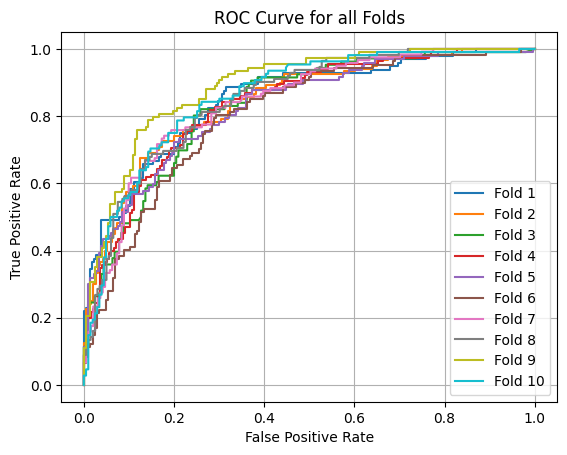

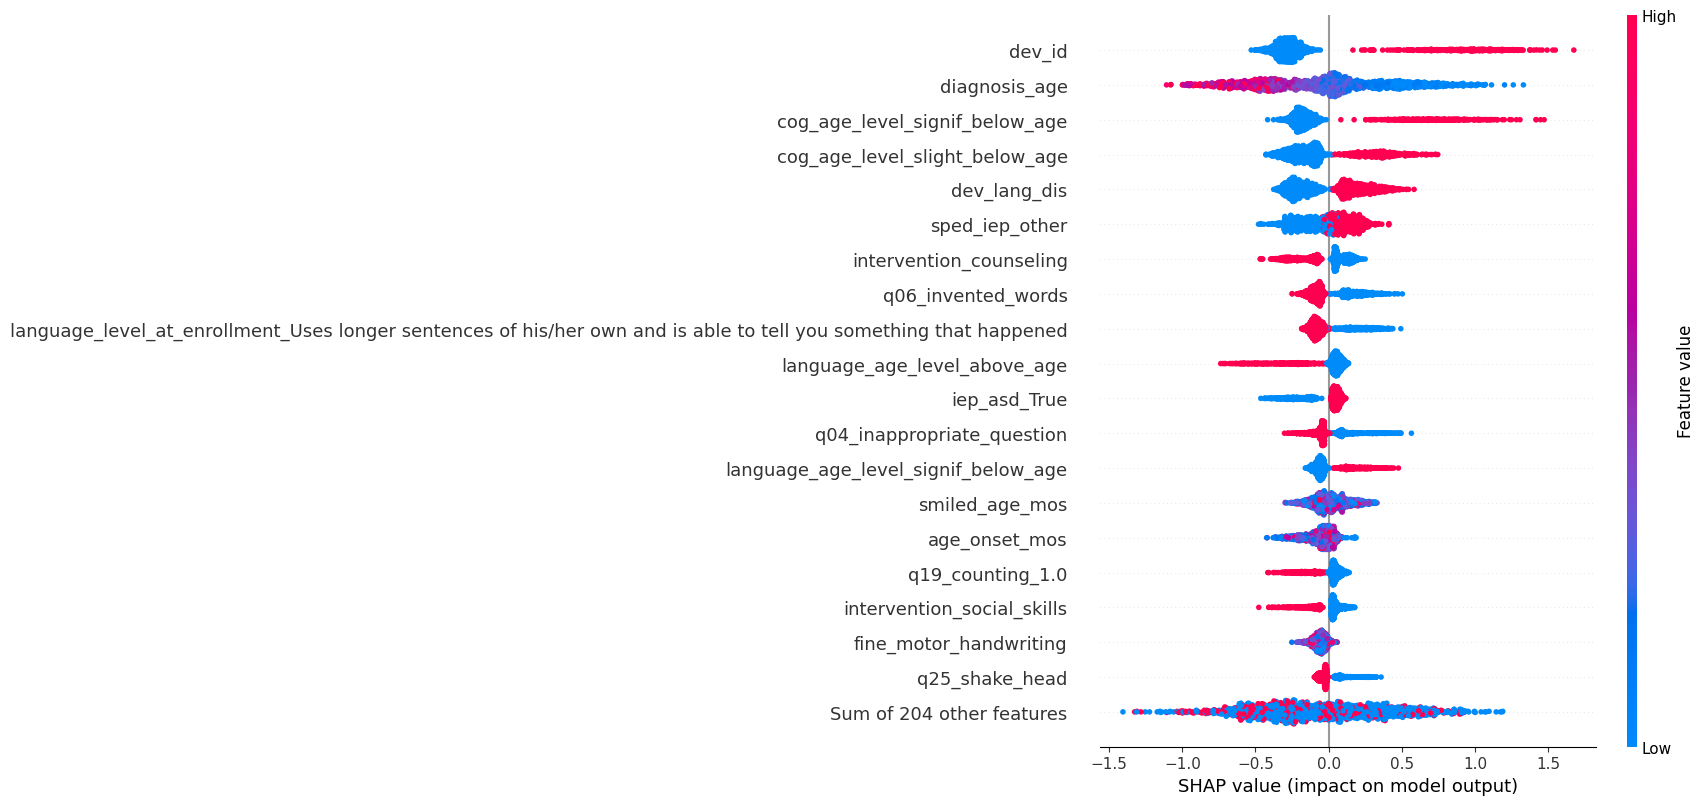

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

import shap

def load_data():
    df = pd.read_csv('ref129_less18_fsiq_1554.csv')
    
    X = df.drop(columns=['subject_sp_id','derived_cog_impair','asd', 'fsiq', 'fsiq_score', 'fsiq_70', 'fsiq_80']) 
    y = df['fsiq_80']
    return X, y, df

def scale_features(X_train, X_val, X_test):
    scaler = MinMaxScaler()
    columns_to_scale = [
        "age_onset_mos",
        "fed_self_spoon_age_mos",
        "smiled_age_mos",
        "fine_motor_handwriting"
    ]
    X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
    X_val[columns_to_scale] = scaler.transform(X_val[columns_to_scale])
    X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    return X_train, X_val, X_test

def balance_classes(X_train, y_train):
    # Use RandomOverSampler to balance the classes
    ros = RandomUnderSampler(random_state=0)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    
    return X_train_resampled, y_train_resampled


def train_model(X_train_scaled, y_train, X_val_scaled, y_val, eval_set, eval_metrics, scale_pos_weight):
    eval_set = [(X_train_scaled, y_train), (X_val_scaled, y_val)]
    model = XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric=eval_metrics, early_stopping_rounds=5, scale_pos_weight=scale_pos_weight)
    model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=True)
    return model

def evaluate_model(model, X_test_scaled, y_test, y_pred, y_pred_proba):
    auc_score = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    f1 = 2 * (prec * sens) / (prec + sens)
    acc = accuracy_score(y_test, y_pred)
    
    return auc_score, cm, prec, acc, sens, spec, f1

def plot_roc_curve():
    plt.title('ROC Curve for all Folds')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

def explain_model(X, model):
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values, max_display=20)
    return shap_values

def main():
    X, y, df = load_data()

    # Cross validation ------------------------
    
    k = 10
    eval_metrics = ["auc"]
    prec_list, acc_list, sens_list, spec_list, f1_list, auc_list = [], [], [], [], [], []
    confusion_matrices = []

    for i in range(k):
        # splitting
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=i)

        # class balancing
        X_train, y_train = balance_classes(X_train, y_train)

        # standardisation
        X_train, X_val, X_test = scale_features(X_train, X_val, X_test)

        eval_set = [(X_train, y_train), (X_val, y_val)]
        scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
        
        model = train_model(X_train, y_train, X_val, y_val, eval_set, eval_metrics, scale_pos_weight)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        # evaluation
        auc_score, cm, prec, acc, sens, spec, f1 = evaluate_model(model, X_test, y_test, y_pred, y_pred_proba)
        
        confusion_matrices.append(cm)
        auc_list.append(auc_score)
        prec_list.append(prec)
        acc_list.append(acc)
        sens_list.append(sens)
        spec_list.append(spec)
        f1_list.append(f1)
        
        # Plot ROC curve for current fold
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'Fold {i+1}')

    # Print results
    avg_auc_score = np.mean(auc_list)
    auc_sd = np.std(auc_list)
    
    avg_prec = np.mean(prec_list)
    prec_sd = np.std(prec_list)
    avg_acc = np.mean(acc_list)
    acc_sd = np.std(acc_list)
    avg_sens = np.mean(sens_list)
    sens_sd = np.std(sens_list)
    avg_spec = np.mean(spec_list)
    spec_sd = np.std(spec_list)
    avg_f1 = np.mean(f1_list)
    f1_sd = np.std(f1_list)
    
    print("\n METRICS: \n")
    print(f"Avg AUC: {avg_prec} ({prec_sd})")
    print(f"Avg Accuracy: {avg_acc} ({acc_sd})")
    print(f"Avg Sensitivity: {avg_sens} ({sens_sd})")
    print(f"Avg Specificity: {avg_spec} ({spec_sd})")
    print(f"Avg f1: {avg_f1} ({f1_sd})")
    
    print("\n Average Confusion Matrix: \n")
    avg_cm = np.mean(confusion_matrices, axis=0)
    print(avg_cm)

    plot_roc_curve()

    # Further evaluation and explanation
    shap_values = explain_model(X, model)

if __name__ == "__main__":
    main()


## in built K-fold CV

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


def load_data():
    df = pd.read_csv('ref129_less18_fsiq_1554.csv')
    
    X = df.drop(columns=['subject_sp_id','derived_cog_impair','asd', 'fsiq', 'fsiq_score', 'fsiq_70', 'fsiq_80']) 
    y = df['fsiq_80']
    return X, y, df

def scale_features(X_train, X_val, X_test):
    scaler = MinMaxScaler()
    columns_to_scale = [
        "age_onset_mos",
        "fed_self_spoon_age_mos",
        "smiled_age_mos",
        "fine_motor_handwriting"
    ]
    X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
    X_val[columns_to_scale] = scaler.transform(X_val[columns_to_scale])
    X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    return X_train, X_val, X_test

def balance_classes(X_train, y_train):
    # Use RandomOverSampler to balance the classes
    ros = RandomUnderSampler(random_state=0)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    
    return X_train_resampled, y_train_resampled


def train_model(X_train_scaled, y_train, X_val_scaled, y_val, eval_set, eval_metrics, scale_pos_weight):
    eval_set = [(X_train_scaled, y_train), (X_val_scaled, y_val)]
    model = XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric=eval_metrics, early_stopping_rounds=5, scale_pos_weight=scale_pos_weight)
    model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=True)
    return model

def evaluate_model(model, X_test_scaled, y_test, y_pred, y_pred_proba):
    auc_score = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    f1 = 2 * (prec * sens) / (prec + sens)
    acc = accuracy_score(y_test, y_pred)
    
    return auc_score, cm, prec, acc, sens, spec, f1

def plot_roc_curve():
    plt.title('ROC Curve for all Folds')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

def explain_model(X, model):
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values, max_display=20)
    return shap_values


from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

        
def main():
    X, y, df = load_data()

    model = XGBClassifier()

    # Define the number of splits for k-fold cross-validation
    k = 5
    
    # Initialize the StratifiedKFold
    stratified_k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Assuming you have a list of column indices or names to scale
    columns_to_scale = [
        "age_onset_mos",
        "fed_self_spoon_age_mos",
        "smiled_age_mos",
        "fine_motor_handwriting"
    ]
    
    # Initialize the ColumnSelector
    column_selector = ColumnSelector(columns=columns_to_scale)
    
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    
    # Define the pipeline with scaling and model
    pipeline = Pipeline([('scaler', scaler), ('model', model)])
    
    # Perform stratified k-fold cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=stratified_k_fold)
    
    # Print the cross-validation scores
    print("Cross-validation scores:", cv_scores)
    print("Mean CV score:", np.mean(cv_scores))

    # Define hyperparameters grid for XGBoost
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.3]
    }
    
    # Perform grid search for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grid, cv=stratified_k_fold, scoring='accuracy')
    grid_search.fit(X, y)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)
    
    # Train the best model on the entire dataset
    best_model.fit(X, y)

    # this test set should ideally be an unseen dataset :

    y_pred_proba = best_model.predict_proba(X)[:, 1]
    y_pred = best_model.predict(X)

    auc_score = roc_auc_score(y, y_pred_proba)
    print(auc_score)

if __name__ == "__main__":
    main()


Cross-validation scores: [0.76527331 0.80707395 0.80385852 0.81350482 0.77741935]
Mean CV score: 0.7934259931542371
Best parameters: {'model__learning_rate': 0.3, 'model__max_depth': 3, 'model__n_estimators': 200}
Best cross-validation score: 0.7998485634270304
0.9999548005438399


# Logistic regression model

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline


def load_data():
    df = pd.read_csv('ref129_less18_fsiq_1554.csv')
    
    X = df.drop(columns=['subject_sp_id','derived_cog_impair','asd', 'fsiq', 'fsiq_score', 'fsiq_70', 'fsiq_80']) 
    y = df['fsiq_80']
    return X, y, df

def scale_features(X_train, X_val, X_test):
    scaler = MinMaxScaler()
    columns_to_scale = [
        "age_onset_mos",
        "fed_self_spoon_age_mos",
        "smiled_age_mos",
        "fine_motor_handwriting"
    ]
    X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
    X_val[columns_to_scale] = scaler.transform(X_val[columns_to_scale])
    X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    return X_train, X_val, X_test

def balance_classes(X_train, y_train):
    # Use RandomOverSampler to balance the classes
    ros = RandomUnderSampler(random_state=0)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    
    return X_train_resampled, y_train_resampled


def train_model(X_train_scaled, y_train, X_val_scaled, y_val, eval_set, eval_metrics, scale_pos_weight):
    eval_set = [(X_train_scaled, y_train), (X_val_scaled, y_val)]
    model = XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric=eval_metrics, early_stopping_rounds=5, scale_pos_weight=scale_pos_weight)
    model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=True)
    return model

def evaluate_model(model, X_test_scaled, y_test, y_pred, y_pred_proba):
    auc_score = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    f1 = 2 * (prec * sens) / (prec + sens)
    acc = accuracy_score(y_test, y_pred)
    
    return auc_score, cm, prec, acc, sens, spec, f1

def plot_roc_curve():
    plt.title('ROC Curve for all Folds')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

def explain_model(X, model):
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values, max_display=20)
    return shap_values


from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

        
def main():
    X, y, df = load_data()

    model = LogisticRegression()
    
    # Initialize the StratifiedKFold
    k = 5
    stratified_k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Assuming you have a list of column indices or names to scale
    columns_to_scale = [
        "age_onset_mos",
        "fed_self_spoon_age_mos",
        "smiled_age_mos",
        "fine_motor_handwriting"
    ]
    
    # Initialize the ColumnSelector
    column_selector = ColumnSelector(columns=columns_to_scale)
    
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    
    # Define the pipeline with scaling and model
    pipeline = Pipeline([('scaler', scaler), ('model', model)])
    
    # Perform stratified k-fold cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=stratified_k_fold, scoring='roc_auc')
    
    # Print the cross-validation scores
    print("Cross-validation scores:", cv_scores)
    print("Mean CV score:", np.mean(cv_scores))

    # Define hyperparameters grid for XGBoost
    param_grid = {
        'model__C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
        'model__penalty': ['l1', 'l2'],  # Penalty term ('l1' for Lasso, 'l2' for Ridge)
        'model__max_iter': [1000, 2000, 3000]
    }
    
    # Perform grid search for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grid, cv=stratified_k_fold, scoring='auc')
    grid_search.fit(X, y)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)
    
    # Train the best model on the entire dataset
    best_model.fit(X, y)

    # this test set should ideally be an unseen dataset :
    y_pred_proba = best_model.predict_proba(X)[:, 1]
    y_pred = best_model.predict(X)

    auc_score = roc_auc_score(y, y_pred_proba)
    print("AUC score:", auc_score)

if __name__ == "__main__":
    main()


D:\SOFTWARE\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\SOFTWARE\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_o

Cross-validation scores: [0.85918919 0.84914414 0.84676617 0.86413388 0.83656818]
Mean CV score: 0.8511603120759836


InvalidParameterError: The 'scoring' parameter of GridSearchCV must be a str among {'neg_median_absolute_error', 'precision_weighted', 'completeness_score', 'recall', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'v_measure_score', 'precision', 'roc_auc_ovr_weighted', 'roc_auc_ovo', 'jaccard_samples', 'neg_root_mean_squared_error', 'roc_auc', 'balanced_accuracy', 'adjusted_rand_score', 'neg_log_loss', 'r2', 'homogeneity_score', 'f1_weighted', 'recall_micro', 'adjusted_mutual_info_score', 'neg_mean_gamma_deviance', 'f1_macro', 'recall_weighted', 'normalized_mutual_info_score', 'jaccard_weighted', 'jaccard', 'explained_variance', 'max_error', 'precision_samples', 'neg_mean_absolute_percentage_error', 'rand_score', 'recall_macro', 'jaccard_micro', 'accuracy', 'f1', 'jaccard_macro', 'precision_macro', 'neg_mean_poisson_deviance', 'neg_negative_likelihood_ratio', 'mutual_info_score', 'neg_brier_score', 'fowlkes_mallows_score', 'neg_mean_squared_error', 'positive_likelihood_ratio', 'f1_micro', 'average_precision', 'matthews_corrcoef', 'precision_micro', 'top_k_accuracy', 'neg_mean_absolute_error', 'f1_samples', 'recall_samples', 'neg_mean_squared_log_error'}, a callable, an instance of 'list', an instance of 'tuple', an instance of 'dict' or None. Got 'auc' instead.